In [1]:
from sklearn.svm import SVC
from sklearn.metrics import scorer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as web

In [2]:
Df= web.DataReader('NSE/TECHM', data_source='quandl')
Df=Df[['Open','High','Low','Close']]


In [3]:
Df['high']=Df['High'].shift(1)
Df['low']=Df['Low'].shift(1)
Df['close']=Df['Close'].shift(1)
Df['Signal']=1
Df['Signal'][Df['Open'].shift(-1)<Df['Open']]=-1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [4]:
print(Df.head())
Df= Df.dropna()


             Open   High     Low   Close   high     low   close  Signal
Date                                                                   
2018-05-18  679.8  697.5  671.25  692.95    NaN     NaN     NaN      -1
2018-05-17  679.0  681.0  666.30  675.80  697.5  671.25  692.95      -1
2018-05-16  671.0  678.7  669.00  672.70  681.0  666.30  675.80      -1
2018-05-15  664.6  680.0  663.30  670.65  678.7  669.00  672.70      -1
2018-05-14  661.6  670.0  658.25  667.25  680.0  663.30  670.65       1


In [5]:
X=Df[['Open','high','low','close']]
y=Df['Signal']

In [6]:
t=.8
split = int(t*len(Df))


In [7]:
reg = SVC(C=1, cache_size=200, class_weight=None, coef0=0,
decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
max_iter=1000, probability=False, random_state=None, shrinking=True,
tol=0.001, verbose=False)
reg.fit(X[:split],y[:split])
y_predict =reg.predict(X[split:])


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [8]:
Df = Df.assign(P_Trend =pd.Series(np.zeros(len(X))).values)
Df['P_Trend'][split:]=y_predict
accuracy = scorer.accuracy_score(Df['Signal'][split:],Df['P_Trend'][split:]) 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
Df = Df.assign(Ret =pd.Series(np.zeros(len(X))).values)
Df['Ret']=np.log(Df['Open'].shift(-1)/Df['Open'])
Df = Df.assign(Ret1 =pd.Series(np.zeros(len(X))).values)
Df['Ret1']=Df['P_Trend']*Df['Ret']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.expanding_std is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).std()
  """




Accuracy: 0.4735576923076923


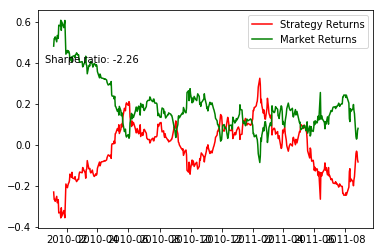

In [10]:
Df = Df.assign(Cu_Ret1 =pd.Series(np.zeros(len(X))).values)
Df['Cu_Ret1']=np.cumsum(Df['Ret1'][split:])
Df = Df.assign(Cu_Ret =pd.Series(np.zeros(len(X))).values)
Df['Cu_Ret']=np.cumsum(Df['Ret'][split:])
Std =pd.expanding_std(Df['Cu_Ret1'])
Sharpe = (Df['Cu_Ret1']-Df['Cu_Ret'])/Std
Sharpe=Sharpe[split:].mean()
print('\n\nAccuracy:',accuracy)
plt.plot(Df['Cu_Ret1'],color='r',label='Strategy Returns')
plt.plot(Df['Cu_Ret'],color='g',label='Market Returns')
plt.figtext(0.14,0.7,s='Sharpe ratio: %.2f'%Sharpe)
plt.legend(loc='best')
